# chairs_chatbox NLP analysis

Generating data on the following:
- Part of Speech
- Dependency Tags

The bulk of this code is adapted from ../../tangrams/preprocessing.ipynb 

In [204]:
from os import path
from collections import Counter

import itertools
import math
import re
import csv
import pandas as pd
import pylab as pyl
import nltk
from pycorenlp import StanfordCoreNLP
from wordcloud import WordCloud

# Read in raw data

In [205]:
msgs = pd.read_csv('../../../data/3dObjects/chairs_chatbox/chairs_chatbox_messages.csv')

# Generate file for POS analysis

Before running this notebook, [get CoreNLP](http://nlp.stanford.edu/software/stanford-corenlp-full-2015-12-09.zip). 

To start CoreNLP server, use the following commands in the CoreNLP home directory:

`java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000`

If you're using port 9000 for something else, change that value and then change `PORT` in the next cell.

In [206]:
PORT = 9000

nlp = StanfordCoreNLP('http://localhost:{}'.format(PORT))

In [207]:
def stanford_pos(text):
    """
    Parameters
    ----------
    text : str
       CoreNLP handles all tokenizing, at the sentence and word level.
       
    Returns
    -------
    list of tuples (str, str)
       The first member of each pair is the word, the second its POS tag.          
    """
    try:
        ann = nlp.annotate(
            text, 
            properties={'annotators': 'pos', 
                        'outputFormat': 'json'})
        lemmas = []
        for sentence in ann['sentences']:
            for token in sentence['tokens']:
                lemmas.append((token['word'], token['pos']))
    except Exception as e:
        print(text + ": cannot parse")
        lemmas = []
    return lemmas

In [208]:
def stanford_constituency(text):
    """
    Parameters
    ----------
    text : str
       CoreNLP handles all tokenizing, at the sentence and word level.
       
    Returns
    -------
    list of tuples (str, str)
       The first member of each pair is the word, the second its POS tag.          
    """
    try:
        ann = nlp.annotate(
            text, 
            properties={'annotators': 'parse', 
                        'outputFormat': 'json'})
        lemmas = []
        for sentence in ann['sentences']:
            for element in sentence['enhancedPlusPlusDependencies']:
                lemmas.append(element)
    except Exception as e:
        print(text,": cannot parse")
        lemmas = []
    return lemmas

In [209]:
from nltk.stem.wordnet import WordNetLemmatizer

LEMMATIZER = WordNetLemmatizer()

def is_comp_sup(word, pos, tags, check_lemmatizer=False):
    """
    Parameters
    ----------
    word, pos : str, str
        The lemma.
    
    tags : iterable of str
        The tags considered positive evidence for comp/sup morphology.
       
       
    check_lemmatizer : bool
        If True, then if the `pos` is in `tags`, we also check that
        `word` is different from the lemmatized version of word
        according to WordNet, treating it as an adjective. This 
        could be used to achieve greater precision, perhaps at the
        expense of recall.
       
    Returns
    -------
    bool       
    """
    if pos not in tags:
        return False
    if check_lemmatizer and LEMMATIZER.lemmatize(word, 'a') == word:
        return False
    return True

def is_noun(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'NN', 'NNS', 'NNP', 'NNPS'}, check_lemmatizer=check_lemmatizer)

def is_prep(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'IN'}, check_lemmatizer=check_lemmatizer)

def is_verb(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'MD', 'VB', 'VBZ', 'VBP', 'VBD', 'VBN', 'VBG'}, check_lemmatizer=check_lemmatizer)

def is_det(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'DT', 'WDT'}, check_lemmatizer=check_lemmatizer)

def is_pronoun(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'PRP', 'PRP$', 'WP', 'WP$'}, check_lemmatizer=check_lemmatizer)

def is_adjective(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'JJ', 'JJR', 'JJS'}, check_lemmatizer=check_lemmatizer)

def is_adverb(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'RB', 'RBR', 'RBS', 'RP', 'WRB'}, check_lemmatizer=check_lemmatizer)

def is_num(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'CD'}, check_lemmatizer=check_lemmatizer)

def is_other(word, pos, check_lemmatizer=False):
    return is_comp_sup(
        word, pos, {'EX', 'FW', 'LS', 'PDT', 'POS', 'SYM', 'TO', 'UH'}, check_lemmatizer=check_lemmatizer)

def is_compound(tags) :
    dependentClauseTags = {'csubj', 'ccomp', 'xcomp', 'advcl'}
    return sum([tag in dependentClauseTags for tag in tags]) > 0

def is_adjectival(tags)  :
    return sum([tag in {'acl', 'acl:relcl'} for tag in tags]) > 0


In [210]:
d = msgs 

# A lemma is a (word, pos) tag pair.
d['lemmas'] = [stanford_pos(text) for text in d['text']]

d['tokens'] = [[element[0] for element in lemma] for lemma in d['lemmas']]
d['pos'] = [[element[1] for element in lemma] for lemma in d['lemmas']]
d['numWords'] = [pd.value_counts(words).sum() for words in d['tokens']]
d['numChars'] = [sum([len(w) for w in words]) for words in d['tokens']]

In [211]:
#Get counts of each POS

d['nouns'] = [sum([1 if is_noun(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['prepositions'] = [sum([1 if is_prep(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['verbs'] = [sum([1 if is_verb(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['determiners'] = [sum([1 if is_det(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['pronouns'] = [sum([1 if is_pronoun(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['adjectives'] = [sum([1 if is_adjective(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['adverbs'] = [sum([1 if is_adverb(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['numbers'] = [sum([1 if is_num(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['others'] = [sum([1 if is_other(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['adj-nouns'] = [sum([1 if (is_adjective(*x) and is_noun(*y)) else 0 for (x,y) in zip(lemmas, lemmas[1:])]) 
                  for lemmas in d['lemmas']]

In [212]:
d['numSuper'] = [sum([1 if label in ['JJS', 'RBS'] else 0 for label in posSet]) 
                 for posSet in d['pos']]
d['numComp'] = [sum([1 if label in ['JJR', 'RBR'] else 0 for label in posSet]) 
                 for posSet in d['pos']]

In [213]:
#the word "chair"
d['w_chair'] = [sum([1 if "chair" in lem else 0 for lem in lemmas])
                      for lemmas in d['lemmas']]
#the word "not"
d['negations'] = [sum([1 if "not" in lem else 0 for lem in lemmas])
                      for lemmas in d['lemmas']]

In [214]:
d['tags'] = [[w['dep'] for w in stanford_constituency(text)] for text in d['text']]
d['full_tags'] = [[w for w in stanford_constituency(text)] for text in d['text']]

In [215]:
d['list_nouns'] = [[lem[0] for lem in lemmas if lem[1] in  ['NN', 'NNS', 'NNP', 'NNPS']] for lemmas in d['lemmas']]

In [216]:
d['pos'][0]

['NN', 'IN', 'DT', 'NN', 'IN', 'DT', 'NN', 'CC', 'DT', 'NN']

In [227]:
d['full_tags'][0][0]

{'dep': 'ROOT',
 'dependent': 1,
 'dependentGloss': 'chair',
 'governor': 0,
 'governorGloss': 'ROOT'}

In [ ]:
#when the root is a noun, count how many modifiers are APs and how many are PPs

In [218]:
all_nouns = [n for nouns in d['list_nouns'] for n in nouns]

all_nouns_str = " ".join(all_nouns)

In [219]:
#Calculate top nouns across all games

top_n = 50     #top n nouns

count = Counter()
for n in all_nouns:
    count[n] += 1

print(pd.DataFrame(count.most_common(top_n)))

            0    1
0       chair  193
1        legs  180
2        seat   74
3        back   72
4        arms   60
5        rest   52
6         top   24
7         arm   23
8       piece   21
9       looks   18
10       hole   17
11      lines   17
12     bottom   17
13     square   16
14     circle   15
15      slats   15
16     chairs   15
17      front   14
18   backrest   14
19      round   14
20        leg   13
21      shape   12
22       desk   12
23       area   11
24      holes   10
25  rectangle   10
26        bar    9
27     toilet    9
28       head    9
29       base    8
30      wheel    8
31     pillow    8
32       lawn    8
33       tank    7
34       bars    7
35       look    7
36     pieces    6
37     middle    6
38    pillows    6
39      thing    6
40      curve    6
41        box    6
42    cushion    5
43     ground    5
44       part    5
45     wheels    5
46      space    5
47   director    5
48        lol    5
49    pattern    4


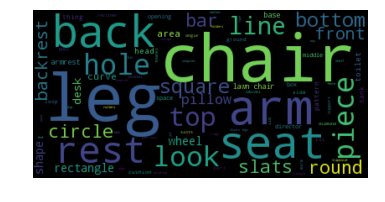

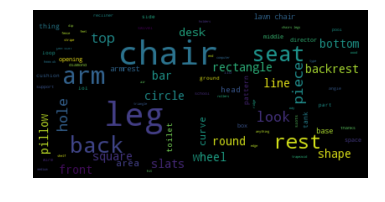

In [220]:
#make a wordcloud
wordcloud = WordCloud().generate(all_nouns_str)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(str(all_nouns_str))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Export to CSV for plotting in R

In [228]:
(d.drop(["Unnamed: 0", "lemmas", "tokens", "full_tags", "list_nouns"], 1)
 .to_csv("posTagged.csv", sep="\t", index = False))